In [ ]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import os.path
import gensim 
from gensim import corpora
from gensim.models import LsiModel
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel
import numpy as np

LOGS = True  # Set to True if you want to see progress in logs.
if LOGS:
    import logging
    logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)


# Reading Web Articles JSON File   
articles_df = pd.read_json('parsedText.json', lines=True)


content = articles_df['text']
ids = articles_df['id']
test = content.head()
words = []
for row in content:
    row.strip()
    words.append(row)

test_list = ' '.join(words)

toeknized = word_tokenize(test_list)
stop_words = list(stopwords.words("english"))
extra = ['(',')','.',']
for i in extra:
    stop_words.append(i)
filtered_list = []

for word in toeknized:
    if word.casefold() not in stop_words:
        filtered_list.append(word)
      


lemmatizer = WordNetLemmatizer()


final_tweets = [lemmatizer.lemmatize(word) for word in filtered_list]


frequency_distribution = FreqDist(final_tweets)

#plt.figure(figsize=(10, 8))
#frequency_distribution.plot(20)
#print(frequency_distribution.most_common(20))
#print(len(ids))


# Doc2Vec

import sys
# !{sys.executable} -m pip install annoy
import annoy
import gensim
import gensim.similarities 
from gensim.similarities.annoy import AnnoyIndexer
from gensim.models.word2vec import Word2Vec
import os
import collections
import smart_open
import random
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

import smart_open

# Method to add web articles to training and testing corpus 
def read_corpus(fname, tokens_only=False):
    count=0
    for doc in content:
        count+=1
        tokens = gensim.utils.simple_preprocess(doc)
        if tokens_only:
            yield tokens
        else:
            # For training data, add tags
            yield gensim.models.doc2vec.TaggedDocument(tokens, [count])

train_corpus = list(read_corpus(content))
test_corpus = list(read_corpus(content, tokens_only=True))

# Build and train Doc2Vec model
model = gensim.models.doc2vec.Doc2Vec(vector_size=100, min_count=2, epochs=20)
model.build_vocab(train_corpus)
model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)

# Note that infer_vector() takes a list of string tokens
ranks = []
second_ranks = []
for doc_id in range(len(train_corpus)):
    inferred_vector = model.infer_vector(train_corpus[doc_id].words)
    sims = model.dv.most_similar([inferred_vector], topn=len(model.dv))
    rank = [docid for docid, sim in sims].index(doc_id)
    ranks.append(rank)

    second_ranks.append(sims[1])
    
"""
print('Document ({}): «{}»\n'.format(doc_id, ' '.join(train_corpus[doc_id].words)))
print(u'SIMILAR/DISSIMILAR DOCS PER MODEL %s:\n' % model)
for label, index in [('MOST', 0), ('SECOND-MOST', 1), ('MEDIAN', len(sims)//2), ('LEAST', len(sims) - 1)]:
    print(u'%s %s: «%s»\n' % (label, sims[index], ' '.join(train_corpus[sims[index][0]].words)))
"""
    
# Pick a random document from the corpus and infer a vector from the model
import random
doc_id = random.randint(0, len(train_corpus) - 1)

# Compare and print the second-most-similar document
#print('Train Document ({}): «{}»\n'.format(doc_id, ' '.join(train_corpus[doc_id].words)))
sim_id = second_ranks[doc_id]
#print('Similar Document {}: «{}»\n'.format(sim_id, ' '.join(train_corpus[sim_id[0]].words)))

# Pick a random document from the test corpus and infer a vector from the model
doc_id = random.randint(0, len(test_corpus) - 1)
inferred_vector = model.infer_vector(test_corpus[doc_id])
sims = model.dv.most_similar([inferred_vector], topn=len(model.dv))

# Compare and print the most/median/least similar documents from the train corpus
#print('Test Document ({}): «{}»\n'.format(doc_id, ' '.join(test_corpus[doc_id])))
#print(u'SIMILAR/DISSIMILAR DOCS PER MODEL %s:\n' % model)
#for label, index in [('MOST', 0), ('MEDIAN', len(sims)//2), ('LEAST', len(sims) - 1)]:
    #print(u'%s %s: «%s»\n' % (label, sims[index], ' '.join(train_corpus[sims[index][0]].words)))
    

######################################################################################################################



In [278]:
# ANNOY

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

from gensim import similarities
import gensim.similarities 
from annoy import AnnoyIndex

# Create ANNOY indexer 100 trees are being used 
# Model is doc2vec model
annoy_index = AnnoyIndexer(model,100)


In [279]:
count = 0
doc = ""
num=0
for doc in content:
    if content[count] == "searching content news news subtitle technology provider recognized exceptional company culture meta news provided may 13 2021 et meta share article annual list based comprehensive measurement american companies created exceptional workplaces company culture whether teams operating person remotely addition audit organization benefits honorees executed employee survey variety topics including management effectiveness perks fostering employee growth onecause offers unique opportunity develop employees personally professionally environment 2020 organization launched onecause cares encouraging employees give back personal causes surface new ideas enhance diversity inclusion safe environment open learning dialogue source onecause sub news releases similar topics":
        num=count
    count+=1
print(ids[num])

# Print query doc 
print(content[1000])
inferred_vector = model.infer_vector(train_corpus[1000].words)
print(inferred_vector)
    
tokenized_content = nltk.word_tokenize(content[1000])
annoyVector = np.array(inferred_vector)
print(annoyVector)


print("\n")
#Results for original doc2Vec model
print(model.dv.most_similar([inferred_vector], topn=10))
doc2vec_result = model.dv.most_similar([inferred_vector], topn=10)
# Print the doc2vec_result and their corresponding cosine similarity values
for result in doc2vec_result:
    print(result)

    
print("\n")
# The instance of AnnoyIndexer we just created is passed 
approximate_neighbors = model.dv.most_similar([annoyVector], topn=10, indexer=annoy_index)
# Print the approximate_neighbors and their corresponding cosine similarity values
for neighbor in approximate_neighbors:
    print(neighbor)
    
# Printing each output doc and their corresponding tags in the JSON file 
print(ids[1000])
print(content[1000])  
print("\n")
print(ids[1065])
print(content[1065])   
print("\n") 
print(ids[1453])
print(content[1453])  
print("\n")
print(ids[1786])
print(content[1786])  
print("\n")
print(ids[990])
print(content[990])   
print("\n")
print(ids[830])
print(content[830]) 
print("\n") 
print(ids[372])
print(content[372])    
print("\n")
print(ids[1788])
print(content[1788])  
print("\n")
print(ids[1468])
print(content[1468])  
print("\n")
print(ids[1503])
print(content[1503])   



1214
searching content news news subtitle technology provider recognized exceptional company culture meta news provided may 13 2021 et meta share article annual list based comprehensive measurement american companies created exceptional workplaces company culture whether teams operating person remotely addition audit organization benefits honorees executed employee survey variety topics including management effectiveness perks fostering employee growth onecause offers unique opportunity develop employees personally professionally environment 2020 organization launched onecause cares encouraging employees give back personal causes surface new ideas enhance diversity inclusion safe environment open learning dialogue source onecause sub news releases similar topics
[-0.24331623 -0.29992023  0.44729182  0.51579064  0.71070653 -0.13164628
  0.17923106  0.5671952  -0.14951126 -0.30433786 -0.21583399 -0.10580225
 -1.0298121   0.03035327 -0.40557733  1.0123681   0.7880762   0.28227916
  0.6330

In [276]:
count = 0
doc = ""
num=0
for id in ids:
    if ids[count] == 346:
        doc = content[count]
        num=count
    count+=1
print(doc)

# Print query doc 
inferred_vector = model.infer_vector(train_corpus[num].words)
print(inferred_vector)
    
tokenized_content = nltk.word_tokenize(content[num])
annoyVector = np.array(inferred_vector)
print(annoyVector)


print("\n")
#Results for original doc2Vec model
print(model.dv.most_similar([inferred_vector], topn=10))
doc2vec_result = model.dv.most_similar([inferred_vector], topn=10)
for result in doc2vec_result:
    print(result)

    
print("\n")
# The instance of AnnoyIndexer we just created is passed 
approximate_neighbors = model.dv.most_similar([annoyVector], topn=10, indexer=annoy_index)
# Print the approximate_neighbors and their corresponding cosine similarity values
for neighbor in approximate_neighbors:
    print(neighbor)
    
# Printing each output doc and their corresponding id in the JSON file 

print(ids[286])
print(content[286])  
print("\n")
print(ids[280])
print(content[280])   
print("\n") 
print(ids[261])
print(content[261])  
print("\n")
print(ids[246])
print(content[246])  
print("\n")
print(ids[235])
print(content[235])    
print("\n")
print(ids[1602])
print(content[1602]) 
print("\n") 
print(ids[1370])
print(content[1370])    
print("\n")
print(ids[274])
print(content[274])  
print("\n")
print(ids[1247])
print(content[1247])  
print("\n")
print(ids[795])
print(content[795])   
print("\n")




news topics reviews car types advice topics find new cars type find cars location drive civic sedan unveiled full later month followed civic hatch later preparations start sedan production honda canadian plant near completion first examples reach american dealers northern summer em honda civic hatch spy civic hatch models bound us showrooms built american soil first time namely indiana swindon uk factory previously serviced us market shut doors later thought standard versions civic hatch bound australia continue built thailand type r production market slated move aforementioned indiana plant line meanwhile expect hear new 2022 honda civic hatch coming months ahead likely australian launch sometime 2022 though official timing yet journalist alex misoyannis writing cars since 2017 started website redline contributed drive 2018 joining caradvice 2019 becoming regular contributing journalist within news team 2020 cars played central role throughout alex life flicking car magazines young ag

In [275]:
count = 0
doc = ""
num=0
for id in ids:
    if ids[count] == 1831:
        doc = content[count]
        num=count
    count+=1
print(doc)
inferred_vector = model.infer_vector(train_corpus[num].words)
print(inferred_vector)
    
tokenized_content = nltk.word_tokenize(content[num])
#vector = model[tokenized_content[1000]]
annoyVector = np.array(inferred_vector)
print(annoyVector)


print("\n")
#Results for original doc2Vec model
print(model.dv.most_similar([inferred_vector], topn=10))
doc2vec_result = model.dv.most_similar([inferred_vector], topn=10)
for result in doc2vec_result:
    print(result)

    
print("\n")
# The instance of AnnoyIndexer we just created is passed 
approximate_neighbors = model.dv.most_similar([annoyVector], topn=10, indexer=annoy_index)
# Print the approximate_neighbors and their corresponding cosine similarity values
for neighbor in approximate_neighbors:
    print(neighbor)
    
    
# Printing each output doc and their corresponding id in the JSON file 

print(ids[1505])
print(content[1505])  
print("\n")
print(ids[1624])
print(content[1624])   
print("\n") 
print(ids[1564])
print(content[1564])  
print("\n")
print(ids[518])
print(content[518])  
print("\n")
print(ids[1604])
print(content[1604])   
print("\n")
print(ids[372])
print(content[372]) 
print("\n") 
print(ids[1816])
print(content[1816])   
print("\n")
print(ids[1000])
print(content[1000])  
print("\n")
print(ids[1030])
print(content[1030])  
print("\n")
print(ids[1769])
print(content[1769])  
print("\n")

print("Annoy")
print(ids[1816])
print(content[1816])   
print("\n")
print(ids[1000])
print(content[1000])  
print("\n")
print(ids[1030])
print(content[1030])
print("\n")
print(ids[1769])
print(content[1769])  
print("\n")
print(ids[1758])
print(content[1758])  
print("\n")


hide find info hide quick links may 10 2021 west lafayette ind livestock producers get firsthand tips incorporate grazing techniques seminars june run northern southern school run friday 8 saturday trainings held two locations course include pasture walks field tours provide opportunities identify forage weed species explore fencing watering options demonstrate rotational grazing concepts also small group discussions seminar experts fellow program participants fee 75 covers management tools materials saturday meal refreshments additional individuals operation permitted cost 50 materials management tools included https noopener agriculture news page purdue university 610 purdue mall west lafayette 47907 765
[-0.41190267 -0.5898589   1.0221027  -0.4773263  -0.08434546 -0.31435552
  0.12174788  0.65303737  0.15922774 -0.8394965  -0.54317343 -0.17284653
 -0.5185889   0.45191386 -0.6084789   1.0985129   0.5497181   0.10683822
  0.51928586  0.4099275   0.28819063  0.34607115  0.69495606 -0.2

In [267]:
# Comparing Gensim's Doc2Vec vs ANNOY runtime

LOGS = True  # Set to True if you want to see progress in logs.
if LOGS:
    import logging
    logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
import matplotlib.pyplot as plt
    
# Set up the model and vector that we are using in the comparison
annoy_index = AnnoyIndexer(model, 100)

# Dry run to make sure both indexes are fully in RAM
normed_vectors = model.dv.get_normed_vectors()
vector = normed_vectors[0]
model.dv.most_similar([vector], topn=10, indexer=annoy_index)
model.dv.most_similar([vector], topn=10)
dv = model.dv

import time
import numpy as np

def avg_query_time(annoy_index=None, queries=1000):
    """Average query time of a most_similar method over 1000 random queries."""
    total_time = 0
    for _ in range(queries):
        rand_vec = normed_vectors[np.random.randint(0, len(dv))]
        start_time = time.process_time()
        model.dv.most_similar([rand_vec], topn=5, indexer=annoy_index)
        total_time += time.process_time() - start_time
    return total_time / queries

queries = 1000

gensim_time = avg_query_time(queries=queries)
annoy_time = avg_query_time(annoy_index, queries=queries)
print("Gensim (s/query):\t{0:.5f}".format(gensim_time))
print("Annoy (s/query):\t{0:.5f}".format(annoy_time))
speed_improvement = gensim_time / annoy_time
print ("\nAnnoy is {0:.2f} times faster on average on this particular run".format(speed_improvement))


Gensim (s/query):	0.00075
Annoy (s/query):	0.00070

Annoy is 1.08 times faster on average on this particular run


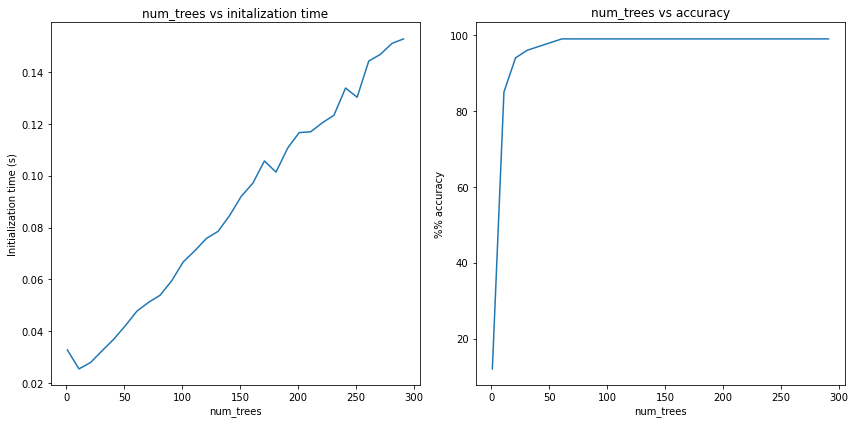

In [273]:
# Num trees vs accuracy 

import matplotlib.pyplot as plt

# Create data set of initialization times and accuracy
# Compute Doc2Vec results 

exact_results = [element[0] for element in model.dv.most_similar([normed_vectors[0]], topn=100)]

x_values = []
y_values_init = []
y_values_accuracy = []

# Testing 1 - 300 trees

for x in range(1, 300, 10):
    x_values.append(x)
    start_time = time.time()
    annoy_index = AnnoyIndexer(model, x)
    y_values_init.append(time.time() - start_time)
    # Compute Annoy reults
    approximate_results = model.dv.most_similar([normed_vectors[0]], topn=100, indexer=annoy_index)
    top_words = [result[0] for result in approximate_results]
    # Compare Doc2Vec and Annoy results 
    y_values_accuracy.append(len(set(top_words).intersection(exact_results)))
    
# Plot results 

plt.figure(1, figsize=(12, 6))
plt.subplot(121)
plt.plot(x_values, y_values_init)
plt.title("num_trees vs initalization time")
plt.ylabel("Initialization time (s)")
plt.xlabel("num_trees")
plt.subplot(122)
plt.plot(x_values, y_values_accuracy)
plt.title("num_trees vs accuracy")
plt.ylabel("%% accuracy")
plt.xlabel("num_trees")
plt.tight_layout()
plt.show()